#Instructions to run this code:

##### This notebook is for EXP4 : i.e., follow up of EXP3 but with a grid size of 700x700

##### This notebook can be run from start to end 

##### Please check and change the data path before running 

##### The results will be saved in the "../results/" folder 

In [1]:
#REFERENCES:
#https://medium.com/@tifa2up/image-classification-using-deep-neural-networks-a-beginner-friendly-approach-using-tensorflow-94b0a090ccd4
#https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-from-scratch-for-mnist-handwritten-digit-classification/

In [2]:
import numpy as np
import pandas as pd
import csv
import cv2
import glob
import shutil
import os
import subprocess
import random
import tensorflow
from tensorflow.keras.models import model_from_json
import sklearn
import scipy
from scipy.ndimage import rotate
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
%matplotlib inline
import matplotlib.pyplot as plt
import pickle
plt.figure(figsize=(12,6))

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

In [3]:
#Change this to local path before running
data_path = '/home/dnyanadajoshi/data/'

#Conceptually global for this notebook
detect = data_path+"detection_data/"
positive_path = detect+"positive/"
negative_path = detect+"negative/"
results = "../results/"
ext = ".bmp"

#TODO: check pros and cons for os, subprocess, shutil - MAKE A NOTE SOMEWHERE
def remove_nonsquares(negative):
    
    files = glob.glob(negative+"*"+ext)
    for f in files:
        img = cv2.imread(f,0)
        if img.shape != (60,60):
            os.remove(f)
            
def create_dataset(path):
    
    files = glob.glob(data_path+"??_cropped/??_?/names_*.csv")
    subprocess.run(["mkdir", detect[:-1]])
    subprocess.run(["mkdir", positive_path[:-1]])
    subprocess.run(["mkdir", negative_path[:-1]])
    output_file = open(detect+"detection_labels.csv","w")
    writer = csv.writer(output_file)
    for fi in files:
        with open(fi,"r") as f:
            reader = csv.reader(f)
            for row in reader:
                (name, label) = tuple(row)
                label_path = negative_path
                if label == '1':
                    label_path = positive_path
                shutil.copyfile(data_path+name, label_path+name.split("/")[-1])
    remove_nonsquares(negative_path)
    files = glob.glob(positive_path+"*"+ext)
    for f in files:
        writer.writerow([f, '1'])
    files = glob.glob(negative_path+"*"+ext)
    for f in files:
        writer.writerow([f, '0'])
    output_file.close()
create_dataset(data_path)

In [4]:
def load_dataset(path, split=0.8):
    X = [[], []]
    #Y = []
    data = []
    with open(path,"r") as f:
        reader = csv.reader(f)
        for row in reader:
            (name, label) = tuple(row)
            img = name
            if label == "1":
                X[1].append(img)
            else:
                X[0].append(img)
        f.close()
        return (X)

X = load_dataset(data_path+"labels-full-700.csv")
random.shuffle(X[0])
random.shuffle(X[1])
print("Positives : ", len(X[1]))
print("Negatives : ", len(X[0]))

Positives :  133
Negatives :  2603


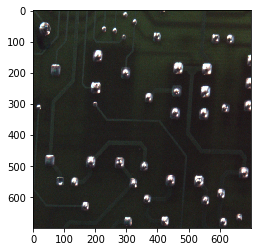

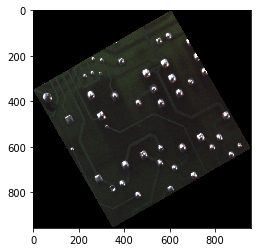

In [5]:
# EXP4 : Generate unmodified augmentations on grid size 700

t_o = 6 #Total image operations: identity, rot90, rot180, rot270, flipUpDown, flipLeftRight
upper_limit = len(X[1])*t_o
del X[0][len(X[1]):]
P = len(X[1])
N = len(X[0])
dummy_img = cv2.imread(X[1][0])
plt.imshow(dummy_img)
plt.show()
plt.imshow(rotate(dummy_img, 30, reshape=True))
plt.show()
(height, width, ch) = dummy_img.shape
Xdata = np.zeros((upper_limit*2, height, width, ch), dtype=np.int8)
for i in range(0):
    img = cv2.imread(X[0][i])
    print(i, t_o*i)
    Xdata[t_o*i] = img
    Xdata[t_o*i+1] = rotate(img, 90, reshape=False)
    Xdata[t_o*i+2] = rotate(img, 180, reshape=False)
    Xdata[t_o*i+3] = rotate(img, 270, reshape=False)
    Xdata[t_o*i+4] = np.flipud(img)
    Xdata[t_o*i+5] = np.fliplr(img)
for i in range(0):
    img = cv2.imread(X[1][i])
    print(i, t_o*i)
    Xdata[upper_limit+t_o*i] = img
    Xdata[upper_limit+t_o*i+1] = rotate(img, 90, reshape=False)
    Xdata[upper_limit+t_o*i+2] = rotate(img, 180, reshape=False)
    Xdata[upper_limit+t_o*i+3] = rotate(img, 270, reshape=False)
    Xdata[upper_limit+t_o*i+4] = np.flipud(img)
    Xdata[upper_limit+t_o*i+5] = np.fliplr(img)

X = Xdata
del Xdata

#EXP2 : Synthetically augment both positives and negatives
##Separate positives and negatives
##You can change upper_limit to control number of negatives picked

upper_limit = 14000
del X[0][len(X[1]):]
X_pos = []
X_neg = []
for p in X[1]:
    img = cv2.imread(p)
    X_pos.append(img)
X_pos_arr = np.asarray(X_pos)
height = X_pos_arr[0].shape[0]
width = X_pos_arr[0].shape[1]
ch = X_pos_arr[0].shape[2]
del X_pos
for n in X[0]:
    img = cv2.imread(n)
    X_neg.append(img)
X_neg_arr = np.asarray(X_neg)
del X_neg

##Data augmentation

N = len(X[0])
P = len(X[1])
ratio = 0.5
sample_factor = int((ratio/(1-ratio))*(upper_limit/P))+1
print(P*sample_factor)
img_gen = ImageDataGenerator(rotation_range=180,horizontal_flip=True, vertical_flip=True, dtype="uint8")
pos_gen = img_gen.flow(X_pos_arr, None, batch_size=len(X[1]))
neg_gen = img_gen.flow(X_neg_arr, None, batch_size=len(X[0]))

Xdata = np.zeros((2*P*sample_factor, height, width, ch), dtype = np.int8) 
for i in range(N): 
    img = cv2.imread(X[0][i]) 
    Xdata[i] = img

    #Load positives after negatives (augmented size)
    img = cv2.imread(X[1][i])
    Xdata[upper_limit+i] = img
del X 
for i in range(sample_factor-1): 
    batch = neg_gen.next() 
    for b in range(len(batch)): 
        Xdata[N + i*b] = batch[b]

for i in range(sample_factor-1): 
    batch = pos_gen.next() 
    for b in range(len(batch)): 
        Xdata[upper_limit + N + i*b] = batch[b]

X = Xdata[:2*upper_limit]
del Xdata

#EXP1 : Synthetically augment only positives
##Separate positives and negatives

upper_limit = 14000
del X[0][upper_limit:]
X_pos = []
X_neg = []
for p in X[1]:
    img = cv2.imread(p)
    X_pos.append(img)
X_pos_arr = np.asarray(X_pos)
height = X_pos_arr[0].shape[0]
width = X_pos_arr[0].shape[1]
ch = X_pos_arr[0].shape[2]
del X_pos

##Data augmentation

N = len(X[0])
P = len(X[1])
ratio = 0.5
sample_factor = int((ratio/(1-ratio))*(upper_limit/P))+1
print(P*sample_factor)
img_gen = ImageDataGenerator(rotation_range=180,horizontal_flip=True, vertical_flip=True, dtype="uint8")
pos_gen = img_gen.flow(X_pos_arr, None, batch_size=len(X[1]))

Xdata = np.zeros((2*P*sample_factor, height, width, ch), dtype = np.int8) 
for i in range(N): 
    img = cv2.imread(X[0][i]) 
    Xdata[i] = img

del X 
for i in range(sample_factor): 
    batch = pos_gen.next() 
    for b in range(len(batch)): 
        Xdata[N + i*b] = batch[b]
X = Xdata[:2*upper_limit]
del Xdata

In [6]:
#suffix for saving data"
#Change this whenever running different experiments
EXP = "_exp4"

Xdata = np.zeros((2*P*sample_factor, height, width, ch), dtype = np.int8)
for i in range(N):
    img = cv2.imread(X[0][i])
    Xdata[i] = img
    
    #Load positives after negatives (augmented size)
    img = cv2.imread(X[1][i])
    Xdata[upper_limit+i] = img

del X
for i in range(sample_factor-1):
    batch = neg_gen.next()
    for b in range(len(batch)):
        Xdata[N + i*b] = batch[b]

for i in range(sample_factor-1):
    batch = pos_gen.next()
    for b in range(len(batch)):
        Xdata[upper_limit + N + i*b] = batch[b]

In [7]:
Y = [0 for i in range(2*upper_limit)]
for i in range(upper_limit):
    Y[upper_limit+i] = 1
Ydata = to_categorical(Y)
del Y
Xdata, Y = sklearn.utils.shuffle(X, Ydata)
#THIS IS OPTIONAL
np.save("../Augmented-data/data"+EXP, Xdata)
np.save("../Augmented-data/labels"+EXP,Y)
del X
del Ydata

In [8]:
print(Xdata.shape)

(1596, 700, 700, 3)


In [9]:
#THIS IS OPTIONAL
Xdata = np.load("../Augmented-data/data"+EXP+".npy")
Ydata = np.load("../Augmented-data/labels"+EXP+".npy")

def data_gen():
    
    batch_pos, labels_pos = aug_gen.next()
    ngen = neg_gen(Xneg, Yneg, 16)
    batch_neg, labels_neg = next(ngen)
    yield np.vstack([batch_pos, batch_neg]), np.vstack([labels_pos, labels_neg])
    
for i in range(2):
    
    #plt.imshow(np.uint8(batch[34]))
    plt.show()
    for i in range(16):
        plt.subplot(4,4,1+i)
        plt.imshow(np.uint8(Xdata[i]))
    counter += 1
    plt.show()
    print(batch.shape, labels.shape)

In [10]:
Xtrain = Xdata[:int(0.8*len(Xdata))]
Xval = Xdata[int(0.8*len(Xdata)):]
Ytrain = Ydata[:int(0.8*len(Ydata))]
Yval = Ydata[int(0.8*len(Ydata)):]
del Xdata
del Ydata

#Data generator
img_gen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, dtype="uint8")
Xtrain = X[:int(0.008*len(X))]
Xtrain = X[:10]
#Xval = X[int(0.8*len(X)):]
Ytrain = Y[:int(0.008*len(Y))]
Ytrain = Y[:10]
#Yval = Y[int(0.8*len(Y)):]
print(sum(np.argmin(Ytrain, axis=1)))
print(len(X), len(Ytrain))
batch_size = 5
train_gen = img_gen.flow(Xtrain, Ytrain, batch_size=batch_size)
#val_gen = img_gen.flow(Xval, Yval, batch_size = 32)
fig = plt.figure()
batch,labels = train_gen.next()
counter = 0
for j in range(2): 
    batch,labels = train_gen.next()
    for i in range(len(batch)):
        plt.subplot(2,5,1+i)
        plt.imshow(np.uint8(batch[i]))
    counter += 1
    plt.show()

In [11]:
(height, width, ch) = Xtrain[0].shape
def Model(learn_rate = 0.01, n_layers=1, n_feature_maps=32,  mm = 0.9, dropout = 0.0):
    model = Sequential()
    for i in range(n_layers):
        model.add(Conv2D(n_feature_maps, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(height, width, ch)))
        model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(dropout))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Dense(2, activation='softmax'))
    # compile model
    opt = SGD(lr=learn_rate, momentum=mm)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model
#plot_model(model, to_file=results+'model.png', show_shapes=True)

In [12]:
#Use sklearn train test split, also use test data separately
model = Model(n_layers=2, dropout=0.5)
#model.fit_generator(train_gen, epochs=3,steps_per_epoch = Xtrain.shape[0]//batch_size, validation_data=(Xval, Yval), verbose = 1)
history = model.fit(x=Xtrain[:32], y=Ytrain[:32], batch_size=32, epochs=20, validation_data=(Xval[:32], Yval[:32]))


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 32 samples, validate on 32 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/20


ResourceExhaustedError: OOM when allocating tensor with shape[32,32,696,696] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node conv2d_1/Conv2D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[{{node metrics/acc/div_no_nan}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


In [46]:

model_json = model.to_json()
with open("model"+EXP+".json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model"+EXP+".h5")

#Grid search 
model = KerasClassifier(build_fn=Model, epochs = 10, batch_size = 32)
lr = [0.01]
layers = [2,3]
features = [32]
dropout = [0.1, 0.5]
param_grid = dict(learn_rate=lr, n_layers = layers, n_feature_maps=features, dropout = dropout)
grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid_result = grid.fit(Xtrain, Ytrain)
save_result = grid_result.cv_results_
print("Mean test scores: ", save_result["mean_test_score"])
print("Params: ", save_result["params"])
pickle.dump(save_result, open("../results/latest_results.p","wb"))
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
for params, mean_score, scores in grid_result.grid_scores_:
    print("%f (%f) with: %r" % (scores.mean(), scores.std(), params))
print("total time:",time()-start)

In [7]:
f = open('../Models/model'+EXP+'.json', 'r')
model = model_from_json(f.read())

# Load weights into the new model
model.load_weights('../Models/model'+EXP+'.h5')
model.compile(optimizer=SGD(lr=0.01, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [13]:
def evaluate(Xtest, Ytest, metrics):
    scores = model.evaluate(Xtest, Ytest,verbose=0)
    for m in range(len(metrics)):
        print(metrics[m],": ",scores[m])
evaluate(Xval, Yval, model.metrics_names)

loss :  1.054973538250202
acc :  0.7426637


In [55]:
#PLEASE RUN THIS CELL TWICE TO SAVE RESULTS (BUG)
print(history.history)
val_acc = history.history['val_acc']
loss = history.history['loss']
acc = history.history['acc']
val_loss = history.history['val_loss']
f = open("results.csv","w")
writer = csv.writer(f)
for i in range(len(val_acc)):
    writer.writerow([acc[i], loss[i], val_acc[i], val_loss[i]])

{'loss': [0.6868061717454489, 0.48334585768835886, 0.363379763638078, 0.19524594357227754, 0.07849135669290111, 0.03332764001940243, 0.02509449514282214, 0.01487481658242302, 0.011958171336641845, 0.005901262227812375, 0.010956620467003205, 0.007320298477250058, 0.007090381129062669, 0.0073656240165065855, 0.006550080909442108, 0.005289557928015398, 0.0022801364679862378, 0.0030897655849862226, 0.0021112927422413884, 0.004311753879412998], 'acc': [0.68887633, 0.77018636, 0.83963865, 0.9240542, 0.97402596, 0.9918125, 0.99322414, 0.9966121, 0.99745905, 0.9985884, 0.9963298, 0.99830604, 0.9988707, 0.9988707, 0.9985884, 0.9980237, 1.0, 0.999153, 1.0, 0.99830604], 'val_loss': [0.9637909986364653, 1.0439255311580597, 2.939597337025283, 0.8156345742281619, 0.963977034420246, 0.893800252447279, 1.2027025470346144, 0.979564025762657, 0.9808354520367176, 0.9972164383322067, 1.1370090195072424, 1.314173578946908, 1.1029499802847749, 1.1240911896826182, 1.234093723663089, 1.1728836316825575, 1.112

In [56]:
df = pd.read_csv("results.csv",header=None, names=["acc", "loss", "val_acc","val_loss"])
val_acc = list(df["val_acc"])
acc = list(df["acc"])
val_loss = list(df["val_loss"])
loss = list(df["loss"])

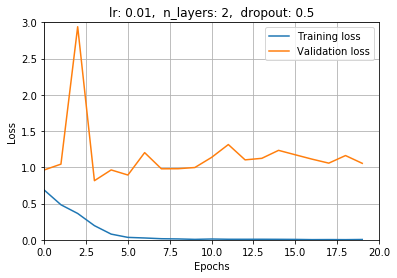

In [61]:
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(df["loss"])
plt.plot(df["val_loss"])
plt.ylim(0, 3)
plt.xlim(0,20)
plt.title("lr: 0.01,  n_layers: 2,  dropout: 0.5")
plt.grid()
plt.legend(['Training loss','Validation loss'],loc="upper right")
plt.savefig("../results/loss_exp3.png")
plt.show()

[9.71221030e-01 2.84634647e-03 9.99965191e-01 2.98858038e-03
 6.49762660e-06 5.61320782e-02 1.59954056e-01 1.36399132e-04
 6.20411299e-02 1.41116036e-02 9.58932505e-04 7.30276387e-03
 1.78173541e-05 3.21415981e-04 9.99832511e-01 2.56353974e-01
 6.42618164e-03 8.39962140e-02 9.92583513e-01 9.36349392e-01
 2.72755593e-01 2.02941090e-01 4.91881877e-01 9.89383519e-01
 9.99954700e-01 1.82260051e-01 4.10642959e-02 1.42357158e-05
 1.84843168e-02 9.95123088e-01 3.36849899e-03 1.21286912e-02
 3.51093593e-03 1.60429336e-03 3.34553123e-01 1.89044490e-01
 9.99763310e-01 9.99878407e-01 9.99435008e-01 9.33358788e-01
 2.44284589e-02 9.91757214e-01 2.72587895e-01 9.96326029e-01
 1.31627067e-03 9.99920249e-01 9.67141032e-01 9.88910913e-01
 9.28112984e-01 5.12004681e-02 9.92865562e-01 1.52698373e-02
 1.01682395e-01 2.52304802e-04 5.99970341e-01 1.36098766e-03
 6.92568114e-03 4.46307240e-04 1.65749213e-03 2.39332706e-01
 9.99868870e-01 6.95243657e-01 2.04097927e-02 4.23087209e-01
 9.92196083e-01 6.410863

Accuracy: 0.742664
Precision: 0.727088
Recall: 0.727088
ROC AUC: 0.188738
[0.0, 0.006772009029345372, 0.010158013544018058, 0.014672686230248307, 0.01580135440180587, 0.020316027088036117, 0.022573363431151242, 0.024830699774266364, 0.03160270880361174, 0.033860045146726865, 0.04288939051918736, 0.045146726862302484, 0.05417607223476298, 0.056433408577878104, 0.09255079006772009, 0.09480812641083522, 1.0]
[[301 134]
 [ 94 357]]
Precision:  0.7270875763747454
Recall:  0.7915742793791575


/home/dnyanadajoshi/anaconda3/envs/project/lib/python3.7/site-packages/sklearn/metrics/ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


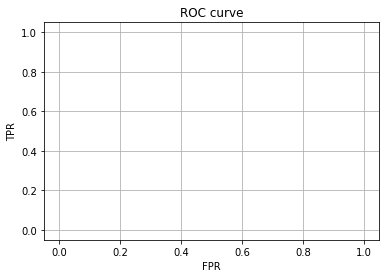

In [8]:
#Metrics
# predict probabilities for test set
from sklearn import metrics
yhat_probs = model.predict(Xval, verbose=0)[:, 0]
# predict crisp classes for test set
yhat_classes = model.predict_classes(Xval, verbose=0)
Yval_ = np.argmax(Yval, axis=1)
accuracy = accuracy_score(Yval_, yhat_classes)
tp_index = []
for i in range(30):
    if Yval_[i] and yhat_classes[i]:
        tp_index.append(i)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(Yval_, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(yhat_classes, Yval_)
print('Recall: %f' % recall)
fpr, tpr, thresholds = metrics.roc_curve(Yval_, yhat_probs, pos_label=2)
auc = roc_auc_score(Yval_,yhat_probs)
print('ROC AUC: %f' % auc)
print(list(fpr))
# confusion matrix
matrix = confusion_matrix(Yval_, yhat_classes)
TN = matrix[0][0]
FP = matrix[0][1]
FN = matrix[1][0]
TP = matrix[1][1]
print(matrix)
plt.xlabel("FPR")
plt.ylabel("TPR")
#Fraction of predicted positives that are actually positive
print("Precision: ", TP/(TP+FP))
#Fraction of positives predicted correctly
print("Recall: ", TP/(TP+FN))
plt.plot(list(fpr),list(tpr), 'ro')
plt.title("ROC curve")
plt.grid()
plt.savefig("../results/roc_curve.png")
plt.show()

In [9]:
for i in range(len(tp_index[:10])):
    cv2.imwrite("../results/true-pos-"+str(i)+".png", np.uint8(Xval[tp_index[i]]) )